# Data Analytics Project - Models

# Pair 2 - ESCORTS ARIMA Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from pmdarima.arima import auto_arima
from sklearn import metrics

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 2 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair2/Pair2_orders.csv')
orders_df.head()

,Date,BEML_Close,ESCORTS_Close,Spread,zscore,Orders
0,2018-08-06,909.099976,880.049988,29.049988,1.821236,SHORT
1,2018-08-07,868.599976,873.700012,-5.100037,0.672698,FLAT
2,2018-08-08,825.150024,876.500000,-51.349976,-0.882785,GET_OUT_OF_POSITION
3,2018-08-09,810.150024,878.750000,-68.599976,-1.462939,FLAT
4,2018-08-10,807.750000,865.250000,-57.500000,-1.089624,FLAT


In [3]:
orders_df.tail()

,Date,BEML_Close,ESCORTS_Close,Spread,zscore,Orders
54,2018-10-29,561.150024,591.450012,-30.299988,-0.174830,FLAT
55,2018-10-30,585.650024,603.950012,-18.299988,0.228756,FLAT
56,2018-10-31,587.250000,627.000000,-39.750000,-0.492654,FLAT
57,2018-11-01,632.400024,674.450012,-42.049988,-0.570007,FLAT
58,2018-11-02,688.900024,676.000000,12.900024,1.278078,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

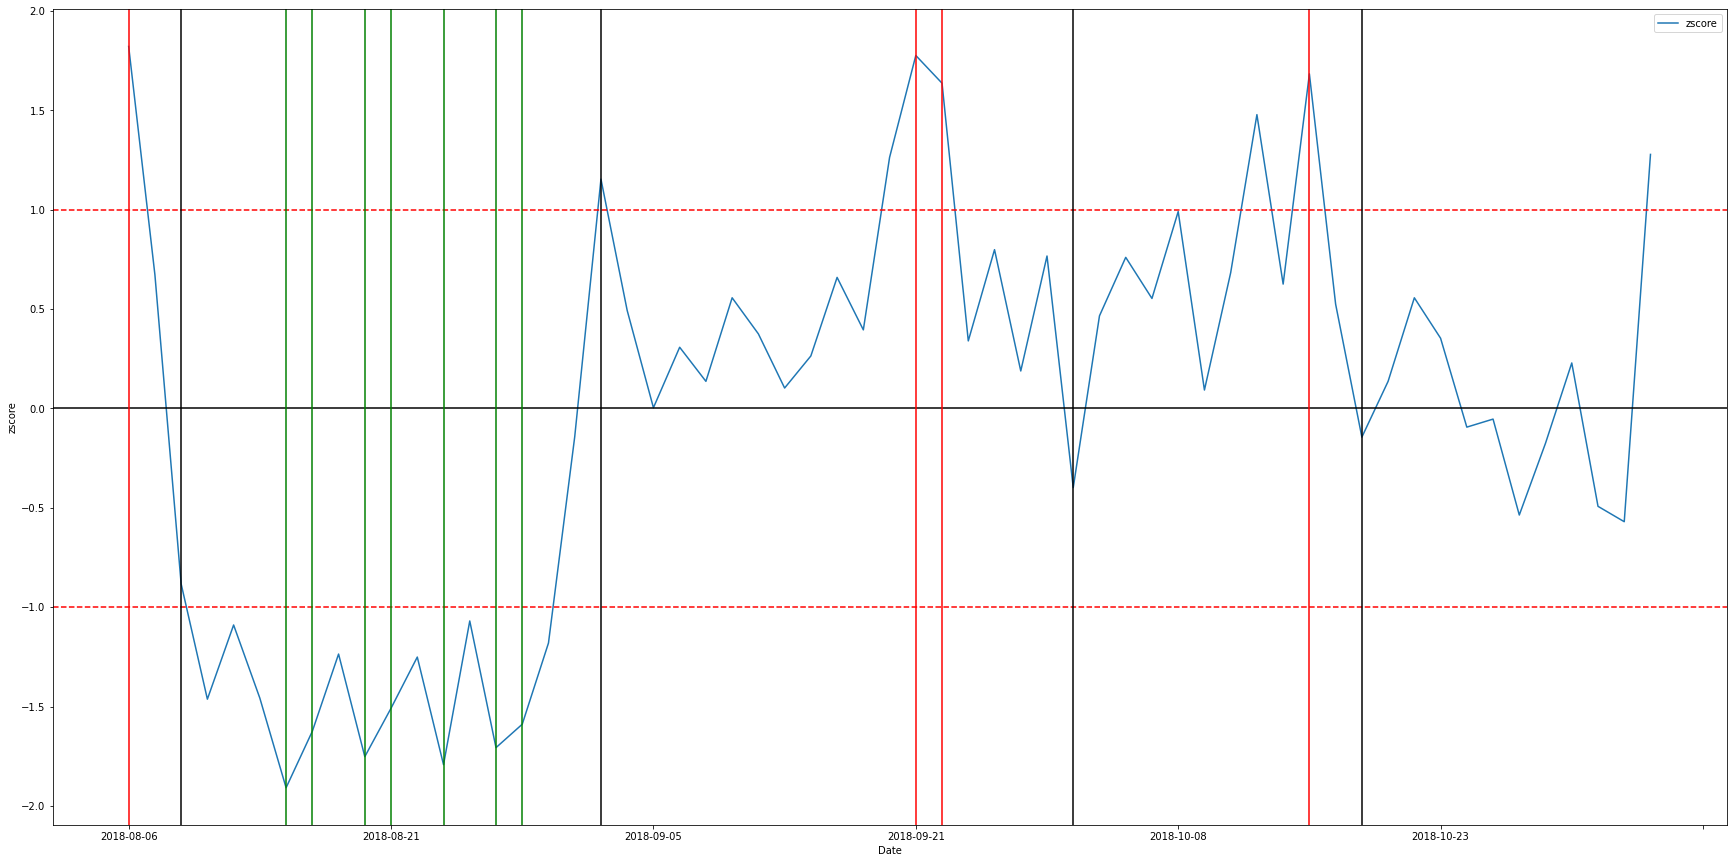

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

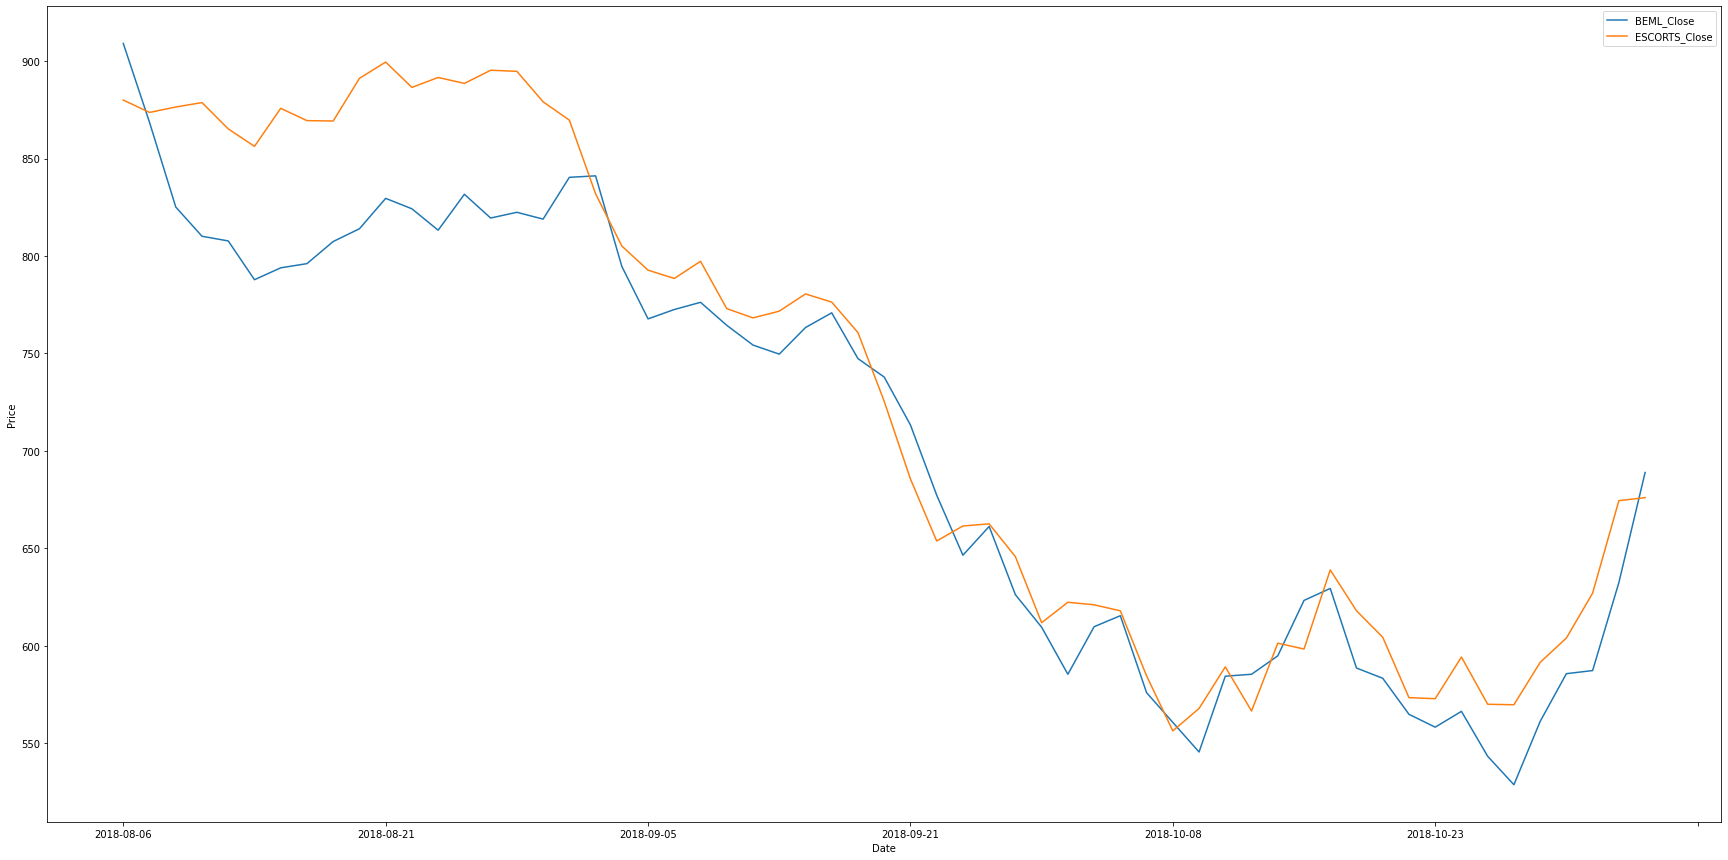

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['BEML_Close', 'ESCORTS_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. ESCORTS Linear Regression Model

## 3.1. Get the Complete ESCORTS dataset

In [6]:
escorts_df = pd.read_csv("../../Storage/Companies_with_names_exchange/ESCORTSNSE.csv")
escorts_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,324.000000,293.500000,298.950012,320.750000,2996742.0,317.104218,ESCORTS,NSE
1,2017-01-03,329.250000,318.750000,321.500000,326.649994,1859220.0,322.937164,ESCORTS,NSE
2,2017-01-04,329.600006,320.049988,326.700012,321.299988,696439.0,317.647980,ESCORTS,NSE
3,2017-01-05,333.000000,322.700012,322.700012,329.549988,1123767.0,325.804199,ESCORTS,NSE
4,2017-01-06,335.000000,320.000000,331.149994,328.250000,862494.0,324.518982,ESCORTS,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get ESCORTS training data

### 3.2.1 Get complete escorts dataset

In [7]:
escorts_df = escorts_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
escorts_df.head()

,Date,Close
0,2017-01-02,320.750000
1,2017-01-03,326.649994
2,2017-01-04,321.299988
3,2017-01-05,329.549988
4,2017-01-06,328.250000


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
escorts_df_train = escorts_df[escorts_df['Date'] >= '2017-09-03']
escorts_df_train.head()

,Date,Close
166,2017-09-04,645.750000
167,2017-09-05,650.299988
168,2017-09-06,651.250000
169,2017-09-07,657.750000
170,2017-09-08,652.950012


In [9]:
escorts_df_train = escorts_df_train[escorts_df_train['Date'] <= '2018-09-04']
escorts_df_train.tail()

,Date,Close
412,2018-08-29,894.799988
413,2018-08-30,879.150024
414,2018-08-31,869.750000
415,2018-09-03,831.950012
416,2018-09-04,805.150024


### 3.2.3 Get the training data and labels

In [10]:
escorts_train = escorts_df_train.copy()
escorts_train

,Date,Close
166,2017-09-04,645.750000
167,2017-09-05,650.299988
168,2017-09-06,651.250000
169,2017-09-07,657.750000
170,2017-09-08,652.950012
...,...,...
412,2018-08-29,894.799988
413,2018-08-30,879.150024
414,2018-08-31,869.750000
415,2018-09-03,831.950012


In [11]:
escorts_train = escorts_train.reset_index(drop=True)
escorts_train = escorts_train['Close']
escorts_train

0      645.750000
1      650.299988
2      651.250000
3      657.750000
4      652.950012
          ...    
246    894.799988
247    879.150024
248    869.750000
249    831.950012
250    805.150024
Name: Close, Length: 251, dtype: float64

In [12]:
len(escorts_train)

251

## 3.3. Get ESCORTS Test Data

In [13]:
escorts_test_df = orders_df.copy()
escorts_test_df = escorts_df[(escorts_df['Date'] >= '2018-09-04') & (escorts_df['Date'] <= '2018-12-03')].copy()
escorts_test_df.head()

,Date,Close
416,2018-09-04,805.150024
417,2018-09-05,792.750000
418,2018-09-06,788.500000
419,2018-09-07,797.299988
420,2018-09-10,773.000000


In [14]:
escorts_test_df.tail()

,Date,Close
470,2018-11-27,689.349976
471,2018-11-28,682.000000
472,2018-11-29,694.549988
473,2018-11-30,704.700012
474,2018-12-03,707.150024


In [15]:
escorts_test = escorts_test_df.copy()
escorts_test.reset_index(drop=True, inplace=True)
escorts_test.index += 251
escorts_test.head()

,Date,Close
251,2018-09-04,805.150024
252,2018-09-05,792.750000
253,2018-09-06,788.500000
254,2018-09-07,797.299988
255,2018-09-10,773.000000


In [16]:
escorts_test.tail()

,Date,Close
305,2018-11-27,689.349976
306,2018-11-28,682.000000
307,2018-11-29,694.549988
308,2018-11-30,704.700012
309,2018-12-03,707.150024


In [17]:
escorts_test = escorts_test['Close']

In [18]:
len(escorts_test)

59

## 3.4 Create and Train ESCORTS Model

In [19]:
model = auto_arima(escorts_train, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(escorts_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.37 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2172.835, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2128.898, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2174.766, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2108.619, Time=1.35 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=10.16 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.26 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2106.625, Time=0.90 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2126.898, Time=0.33 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=7.45 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.32 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2108.618, Time=1.36 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=2109.514, Time=3.65 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=2108.

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

## 3.5. Get predictions

In [20]:
forecast = model.predict(n_periods=len(escorts_test))
forecast = pd.DataFrame(forecast, index = escorts_test.index, columns=['Prediction'])
forecast

,Prediction
251,814.415519
252,807.619558
253,816.193006
254,799.530341
255,790.553107
256,789.476776
257,795.684769
258,800.431765
259,794.861088
260,789.315227


In [21]:
predictions = forecast['Prediction']
print('Mean Absolute Error:', metrics.mean_absolute_error(escorts_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(escorts_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(escorts_test, predictions)))

Mean Absolute Error: 74.3617453715735
Mean Squared Error: 9035.193724722436
Root Mean Squared Error: 95.0536360415657


## 3.6. Visualize the predicitons vs test data

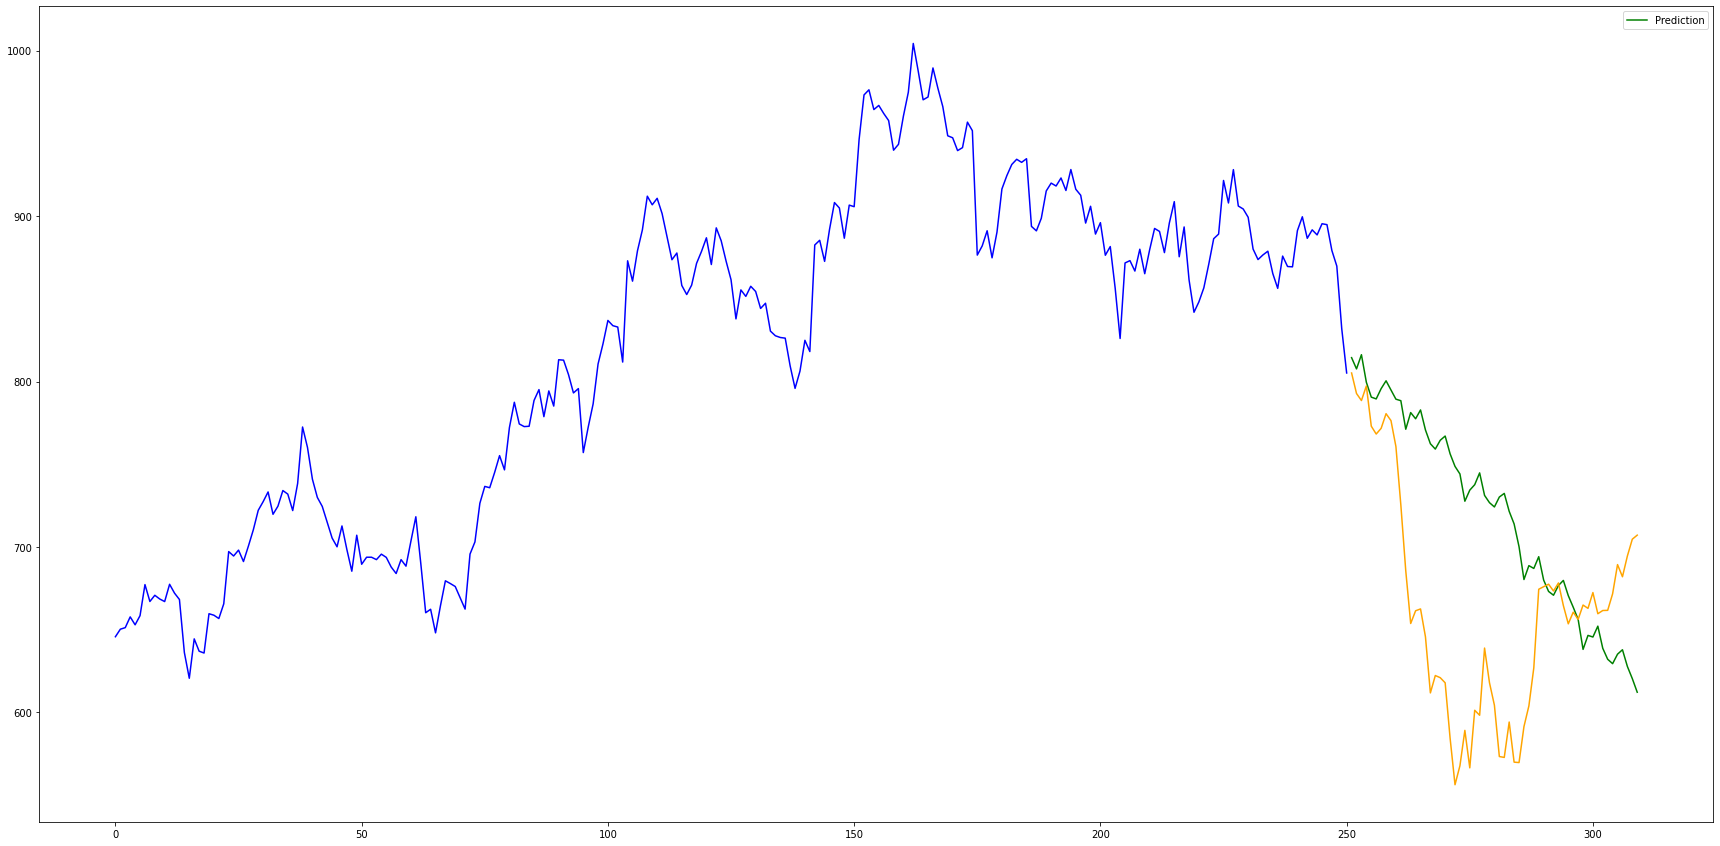

In [22]:
escorts_model_plt = forecast.plot(y=['Prediction'], figsize=(30,15), c='green')
escorts_model_plt.plot(escorts_train, c='blue')
escorts_model_plt.plot(escorts_test, c='orange')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [23]:
escorts_predictions_df = pd.read_csv('Escorts_predicitions.csv')
escorts_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2018-08-06,880.049988,894.957322
1,2018-08-07,873.700012,896.301668
2,2018-08-08,876.500000,897.646014
3,2018-08-09,878.750000,898.990361
4,2018-08-10,865.250000,896.179214


In [24]:
forecast = forecast.reset_index()
forecast = forecast.drop(columns='index')
escorts_predictions_df['ARIMA_Close'] = forecast['Prediction']
escorts_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
0,2018-08-06,880.049988,894.957322,814.415519
1,2018-08-07,873.700012,896.301668,807.619558
2,2018-08-08,876.500000,897.646014,816.193006
3,2018-08-09,878.750000,898.990361,799.530341
4,2018-08-10,865.250000,896.179214,790.553107


In [25]:
escorts_predictions_df.to_csv('Escorts_predicitions.csv', index=False)